# Trabajo Practico 1

Estudiantes:

- Alonso Araya Calvo
- Pedro Soto
- Sofia Oviedo

# Imports

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

# Cargando dataset

In [4]:
#tomado de https://www.kaggle.com/code/wailinnoo/intrusion-detection-system-using-kdd99-dataset
import pandas as pd
from tensorflow.keras.utils import get_file

try:
    path = get_file('kddcup.data_10_percent.gz', origin='http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz')
except:
    print('Error downloading')
    raise

print(path)

# This file is a CSV, just no CSV extension or headers
# Download from: http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html
pd_data_frame = pd.read_csv(path, header=None)

# The CSV file has no column heads, so add them
pd_data_frame.columns = [
    'duration',
    'protocol_type',
    'service',
    'flag',
    'src_bytes',
    'dst_bytes',
    'land',
    'wrong_fragment',
    'urgent',
    'hot',
    'num_failed_logins',
    'logged_in',
    'num_compromised',
    'root_shell',
    'su_attempted',
    'num_root',
    'num_file_creations',
    'num_shells',
    'num_access_files',
    'num_outbound_cmds',
    'is_host_login',
    'is_guest_login',
    'count',
    'srv_count',
    'serror_rate',
    'srv_serror_rate',
    'rerror_rate',
    'srv_rerror_rate',
    'same_srv_rate',
    'diff_srv_rate',
    'srv_diff_host_rate',
    'dst_host_count',
    'dst_host_srv_count',
    'dst_host_same_srv_rate',
    'dst_host_diff_srv_rate',
    'dst_host_same_src_port_rate',
    'dst_host_srv_diff_host_rate',
    'dst_host_serror_rate',
    'dst_host_srv_serror_rate',
    'dst_host_rerror_rate',
    'dst_host_srv_rerror_rate',
    'outcome'
]

/Users/aaraya/git/KDD99-TLP/.venv/lib/python3.9/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
/Users/aaraya/git/KDD99-TLP/.venv/lib/python3.9/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
/Users/aaraya/git/KDD99-TLP/.venv/lib/python3.9/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/resource_handle.proto. Please 

/Users/aaraya/.keras/datasets/kddcup.data_10_percent.gz


# Limpieza del dataset y generacion de subset del dataset

In [5]:
# For now, just drop NA's (rows with missing values), in case there are
pd_data_frame.dropna(inplace=True,axis=1)

# Checking for DUPLICATE values
pd_data_frame.drop_duplicates(keep='first', inplace = True)

In [6]:
# Filter the DataFrame to keep only 'normal.' and 'back.' outcomes
filtered_df = pd_data_frame[pd_data_frame['outcome'].isin(['normal.', 'back.'])].copy()

In [7]:
list_nominal_features = ["flag", "protocol_type", "service"]

# Apply one-hot encoding to the nominal features
df_encoded = pd.get_dummies(filtered_df, columns=list_nominal_features)

# Convert boolean columns (from one-hot encoding) to integers (0 or 1) in df_encoded
for col in df_encoded.columns:
    if df_encoded[col].dtype == 'bool':
        df_encoded[col] = df_encoded[col].astype(int)

In [8]:
df_attacks = df_encoded[df_encoded['outcome'] == 'back.'].copy()
df_no_attacks = df_encoded[df_encoded['outcome'] == 'normal.'].copy()

# Parte 1 Análisis Descriptivo
## 1a Analisis de momentos estadisticos

- Media
- Desviacion estandar
- Inclinacion
- Kurtosis

In [9]:
df_attacks_without_outcome = df_attacks.drop('outcome', axis=1)
df_no_attacks_without_outcome = df_no_attacks.drop('outcome', axis=1)

attack_without_outcomes_column_names = df_attacks_without_outcome.columns
attack_tensor = torch.tensor(df_attacks_without_outcome.values, dtype=torch.float32)

no_attack_without_outcomes_column_names = df_no_attacks_without_outcome.columns
no_attack_tensor = torch.tensor(df_no_attacks_without_outcome.values, dtype=torch.float32)

In [10]:
def calculate_moments(dataset_tensor, feature_names):
    means = torch.mean(dataset_tensor, dim=0)
    stds = torch.std(dataset_tensor, dim=0)

    z = (dataset_tensor - means) / stds

    z = torch.where(torch.isfinite(z), z, torch.zeros_like(z))

    skews = torch.mean(z**3, dim=0)
    kurts = torch.mean(z**4, dim=0) - 3

    stats_df = pd.DataFrame({
        "Media": means.numpy(),
        "Desviación Estándar": stds.numpy(),
        "Inclinación": skews.numpy(),
        "Kurtosis": kurts.numpy()
    }, index=feature_names)

    display(stats_df)

### Momentos Estadisticos para Datos de Ataque

In [11]:
calculate_moments(attack_tensor, attack_without_outcomes_column_names)

,Media,Desviación Estándar,Inclinación,Kurtosis
duration,0.293388,1.660627,6.201858,39.309826
src_bytes,53666.890625,4722.463867,-6.375224,42.617058
dst_bytes,8129.908203,919.138550,-5.915854,35.871834
land,0.000000,0.000000,0.000000,-3.000000
wrong_fragment,0.000000,0.000000,0.000000,-3.000000
...,...,...,...,...
service_tftp_u,0.000000,0.000000,0.000000,-3.000000
service_tim_i,0.000000,0.000000,0.000000,-3.000000
service_time,0.000000,0.000000,0.000000,-3.000000
service_urh_i,0.000000,0.000000,0.000000,-3.000000


In [12]:
stats_df = pd.DataFrame(index=df_attacks_without_outcome.columns)
stats_df["Mean"] = df_attacks_without_outcome.mean()
stats_df["Std"] = df_attacks_without_outcome.std()
stats_df["Skewness"] = df_attacks_without_outcome.skew()
stats_df["Kurtosis"] = df_attacks_without_outcome.kurt()

display(stats_df)

,Mean,Std,Skewness,Kurtosis
duration,0.293388,1.660627,6.221125,39.607862
src_bytes,53666.892562,4722.463858,-6.395032,42.939136
dst_bytes,8129.908058,919.138524,-5.934233,36.144889
land,0.000000,0.000000,0.000000,0.000000
wrong_fragment,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...
service_tftp_u,0.000000,0.000000,0.000000,0.000000
service_tim_i,0.000000,0.000000,0.000000,0.000000
service_time,0.000000,0.000000,0.000000,0.000000
service_urh_i,0.000000,0.000000,0.000000,0.000000


### Momentos Estadisticos para Paquetes Normales

In [13]:
calculate_moments(no_attack_tensor, no_attack_without_outcomes_column_names)

,Media,Desviación Estándar,Inclinación,Kurtosis
duration,188.932388,1320.953003,10.840396,164.942474
src_bytes,1270.249146,36017.765625,59.171650,3578.733887
dst_bytes,3720.620850,39526.839844,70.640572,6578.883301
land,0.000011,0.003374,296.354523,87825.000000
wrong_fragment,0.000000,0.000000,0.000000,-3.000000
...,...,...,...,...
service_tftp_u,0.000011,0.003374,296.354523,87825.000000
service_tim_i,0.000023,0.004772,209.550690,43909.996094
service_time,0.000398,0.019958,50.063965,2504.428955
service_urh_i,0.000159,0.012624,79.186501,6268.572266


In [14]:
stats_df = pd.DataFrame(index=df_no_attacks_without_outcome.columns)
stats_df["Mean"] = df_no_attacks_without_outcome.mean()
stats_df["Std"] = df_no_attacks_without_outcome.std()
stats_df["Skewness"] = df_no_attacks_without_outcome.skew()
stats_df["Kurtosis"] = df_no_attacks_without_outcome.kurt()

display(stats_df)

,Mean,Std,Skewness,Kurtosis
duration,188.932394,1320.952947,10.840767,164.955803
src_bytes,1270.249226,36017.765413,59.173673,3579.019616
dst_bytes,3720.620423,39526.841178,70.642967,6579.405283
land,0.000011,0.003374,296.364640,87832.000000
wrong_fragment,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...
service_tftp_u,0.000011,0.003374,296.364640,87832.000000
service_tim_i,0.000023,0.004772,209.557868,43913.499909
service_time,0.000398,0.019958,50.065674,2504.628760
service_urh_i,0.000159,0.012624,79.189195,6269.071386


## 1b Histogramas y Distancia Jensen Shannon

### Histogramas para datos de ataque backdoor

In [15]:
from scipy.spatial.distance import jensenshannon

def analyze_js_distance_separated(df_normal, df_backdoor, feature_names, bins=30):
    js_distances = []

    for feat in feature_names:
        normal_vals = df_normal[feat].values
        backdoor_vals = df_backdoor[feat].values

        hist_range = (min(normal_vals.min(), backdoor_vals.min()),
                      max(normal_vals.max(), backdoor_vals.max()))

        hist_normal, _ = np.histogram(normal_vals, bins=bins, range=hist_range, density=True)
        hist_backdoor, _ = np.histogram(backdoor_vals, bins=bins, range=hist_range, density=True)

        jsd = jensenshannon(hist_normal, hist_backdoor)
        js_distances.append(jsd)

        plt.figure(figsize=(6,4))
        plt.hist(normal_vals, bins=bins, range=hist_range, alpha=0.5, label="Normal", color='blue', density=True)
        plt.hist(backdoor_vals, bins=bins, range=hist_range, alpha=0.5, label="Backdoor", color='red', density=True)
        plt.title(f"{feat} (JS Distancia: {jsd:.4f})")
        plt.xlabel("Valor")
        plt.ylabel("Densidad")
        plt.legend()
        plt.show()

    js_df = pd.DataFrame({
        "Feature": feature_names,
        "JS_Distancia": js_distances
    }).sort_values(by="JS_Distancia", ascending=False)

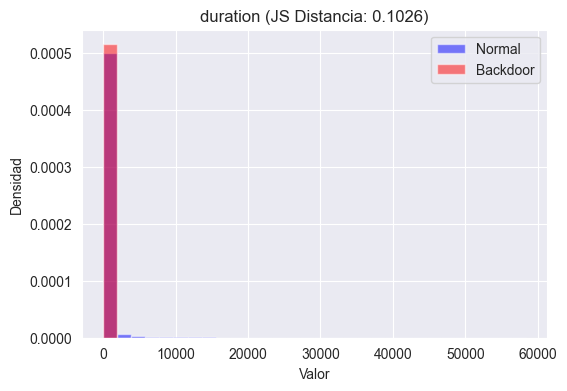

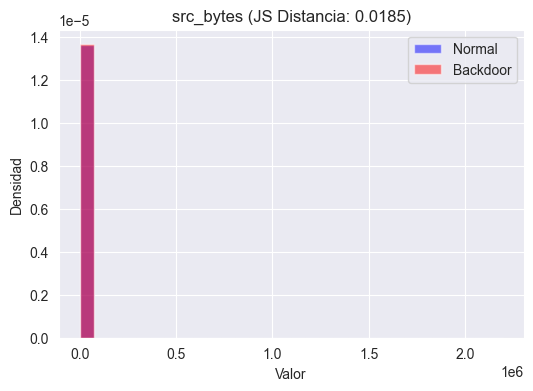

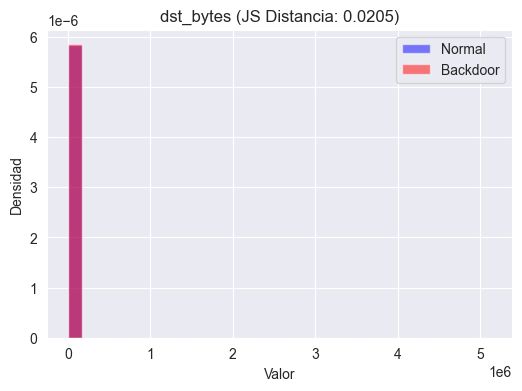

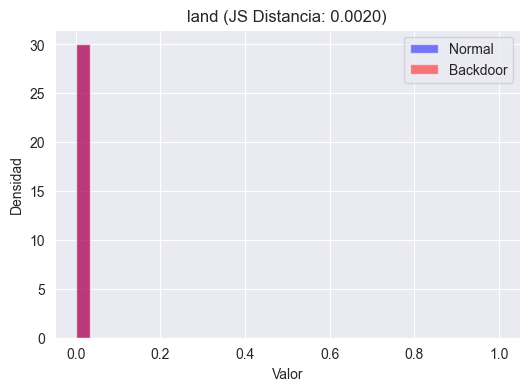

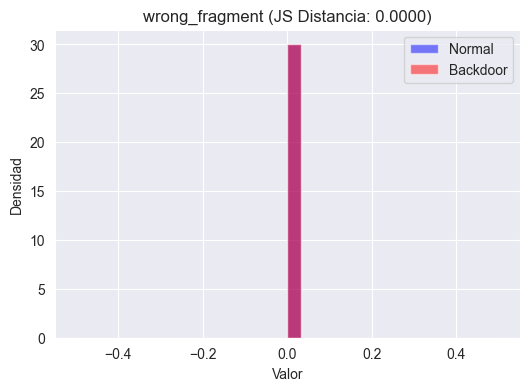

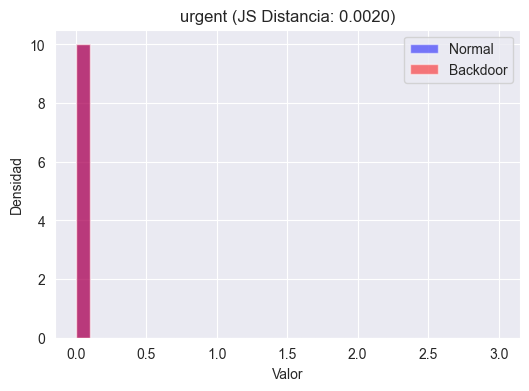

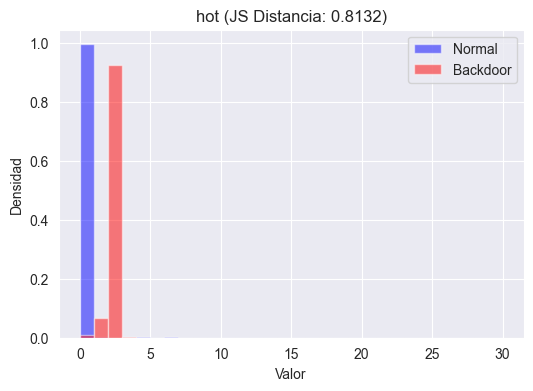

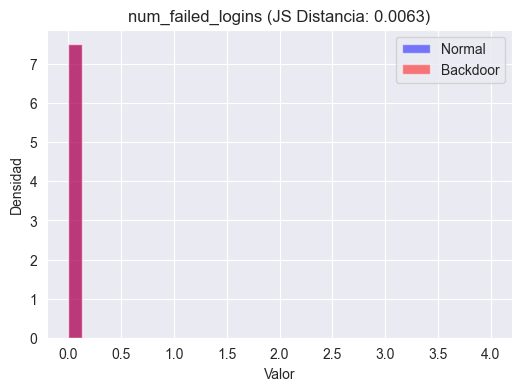

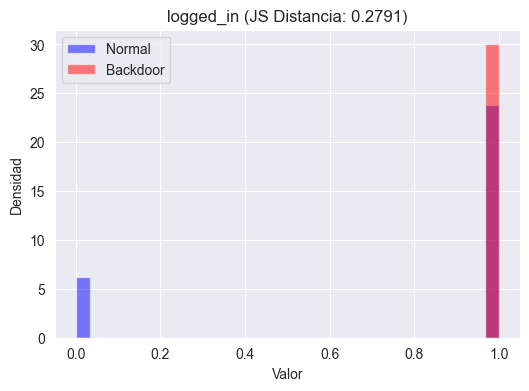

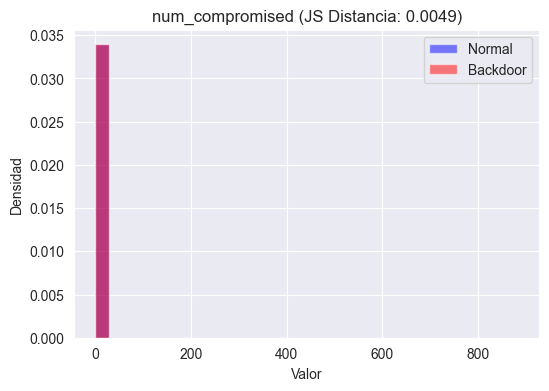

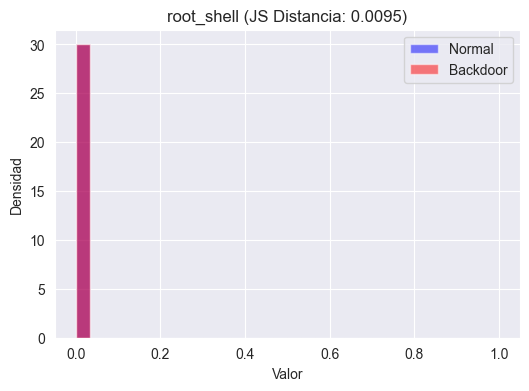

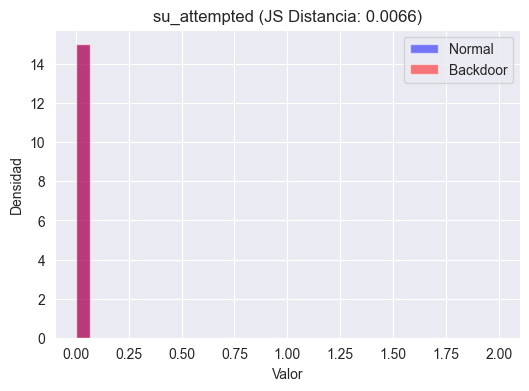

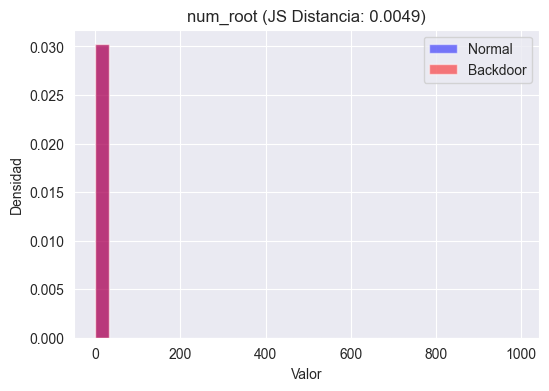

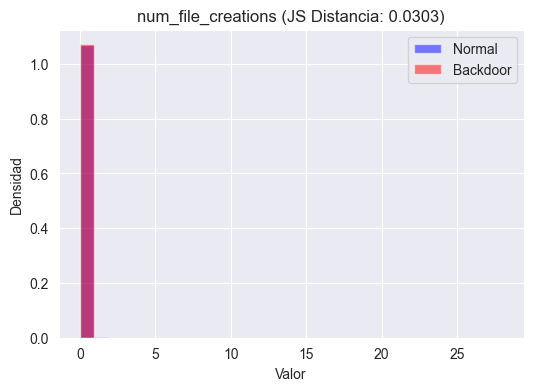

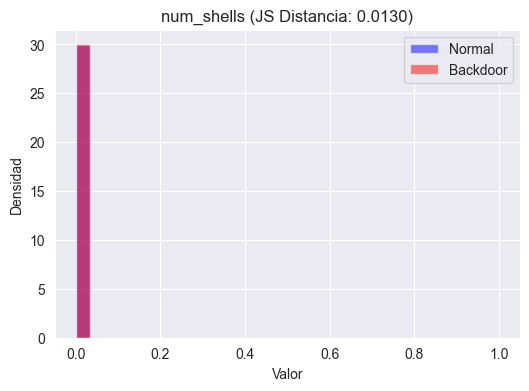

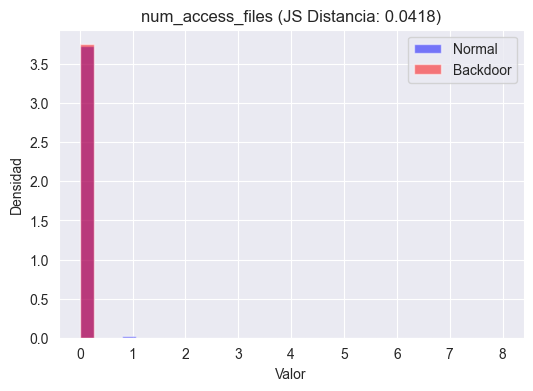

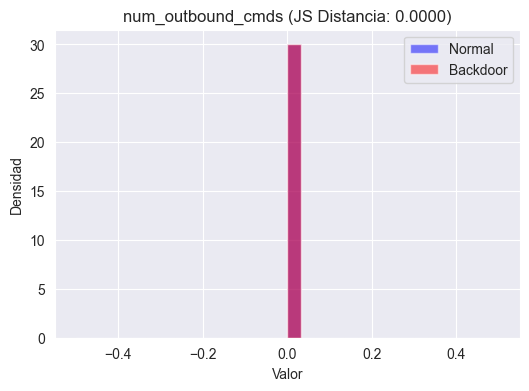

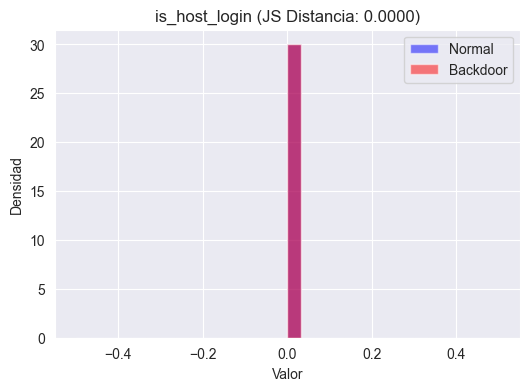

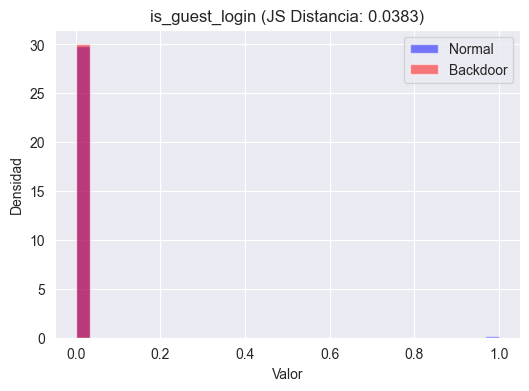

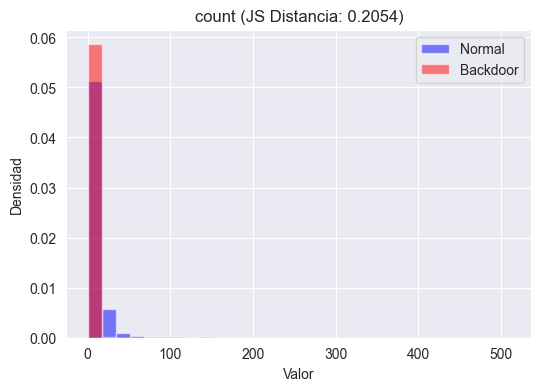

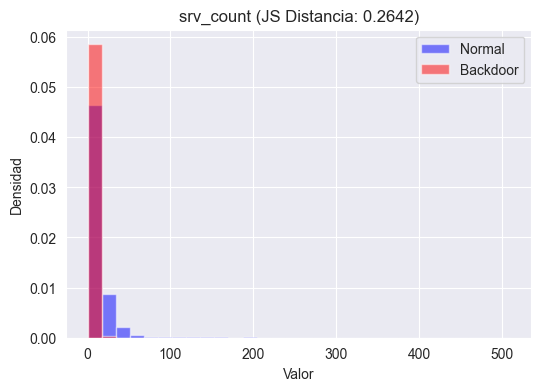

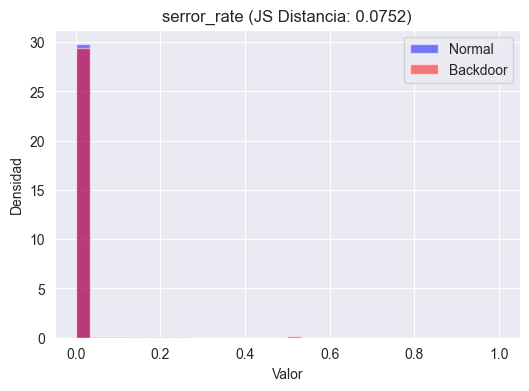

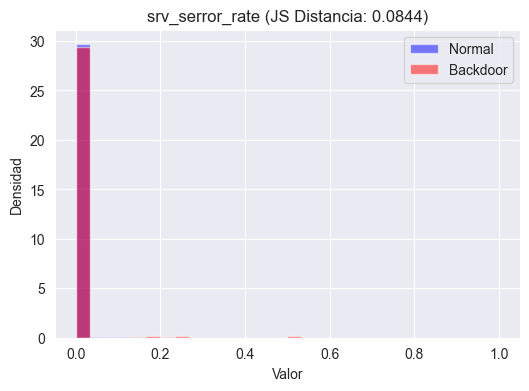

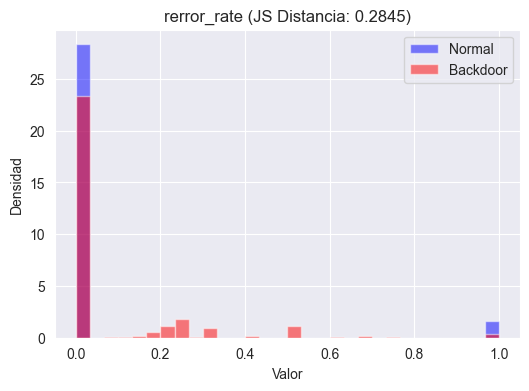

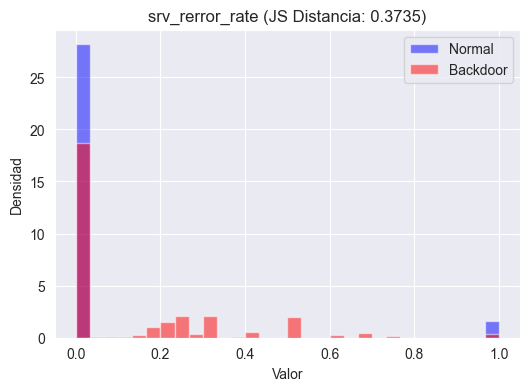

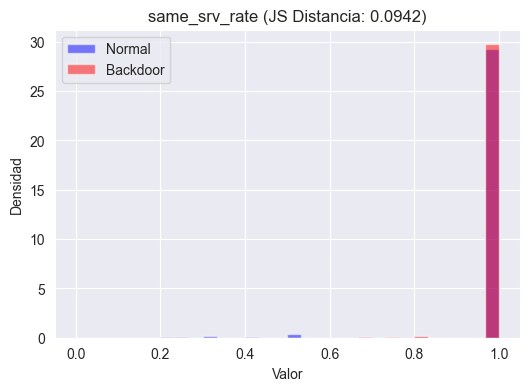

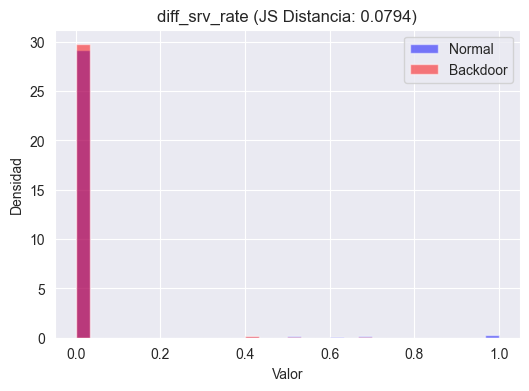

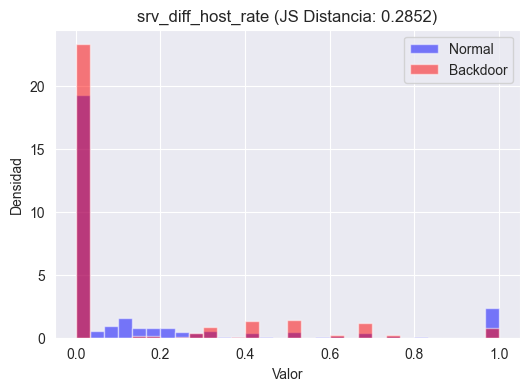

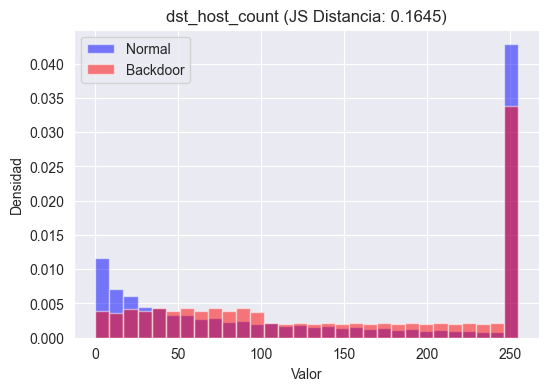

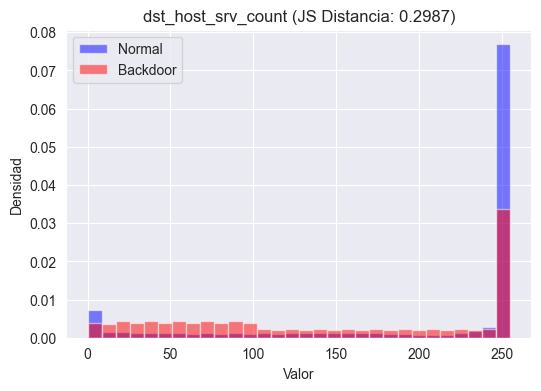

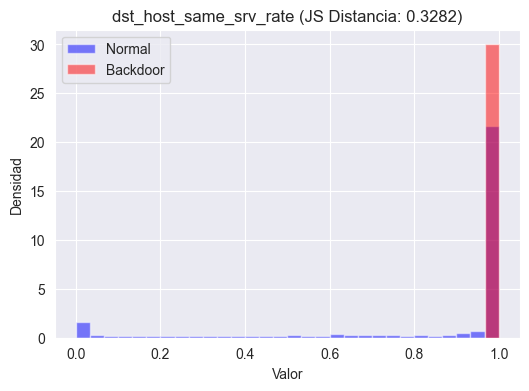

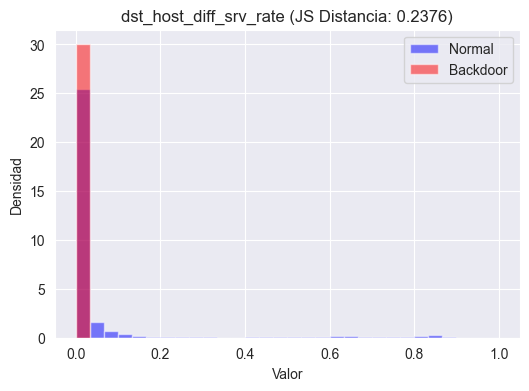

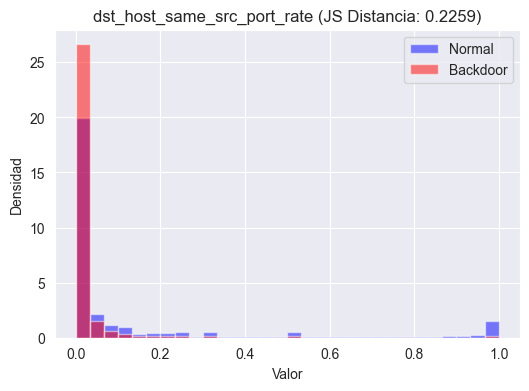

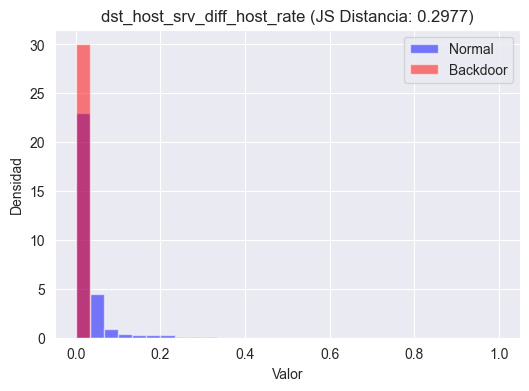

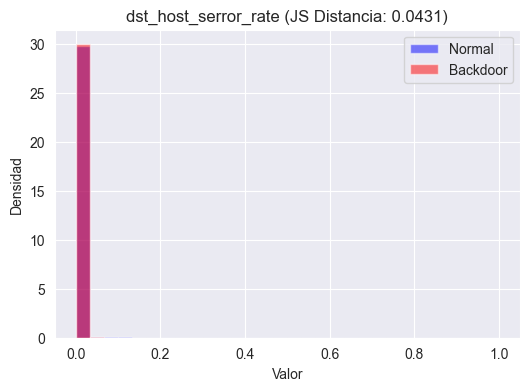

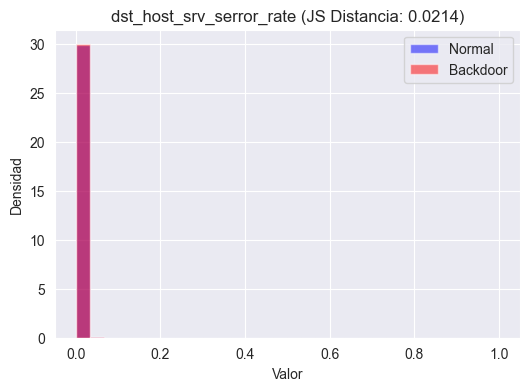

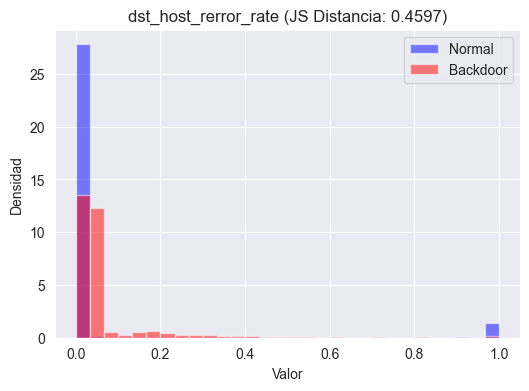

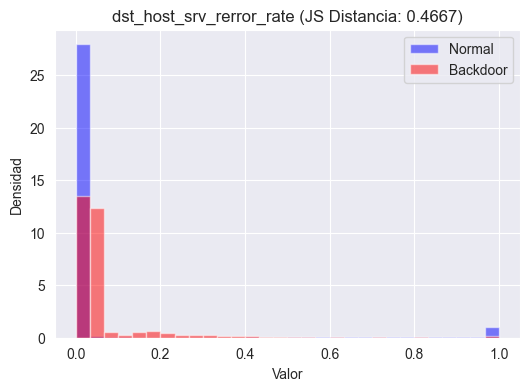

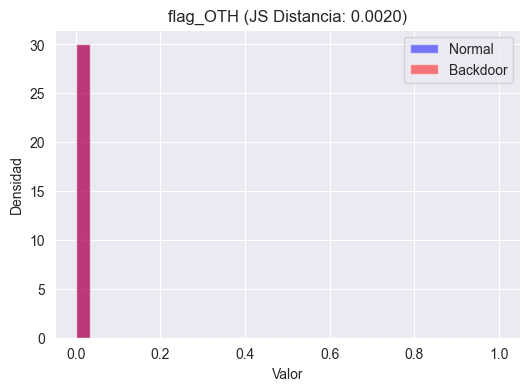

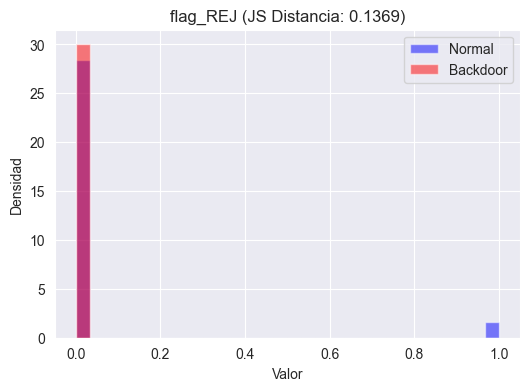

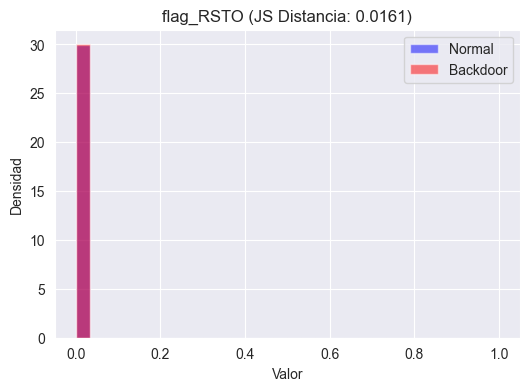

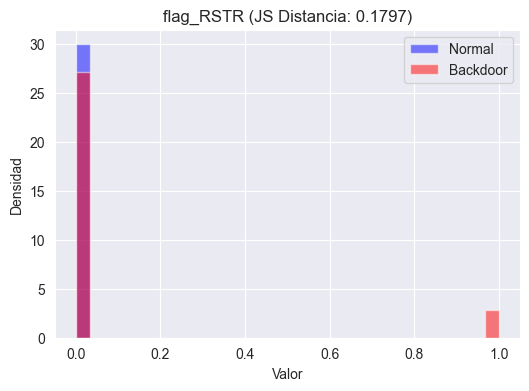

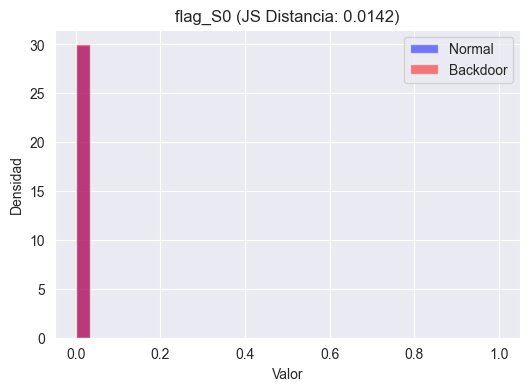

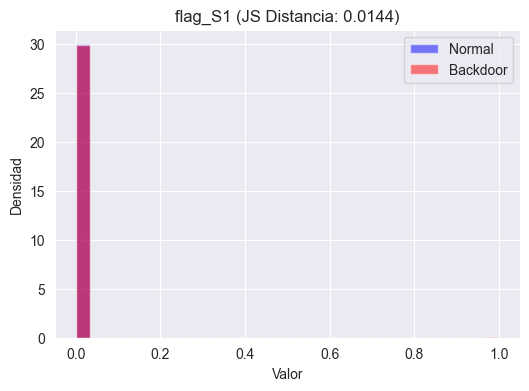

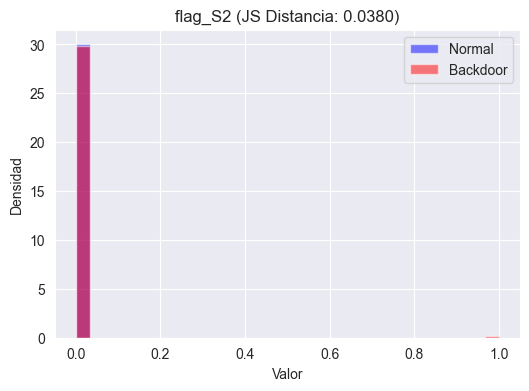

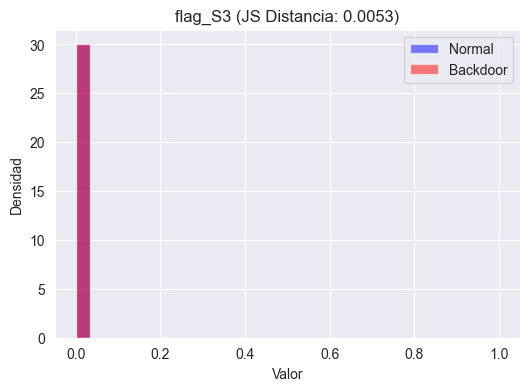

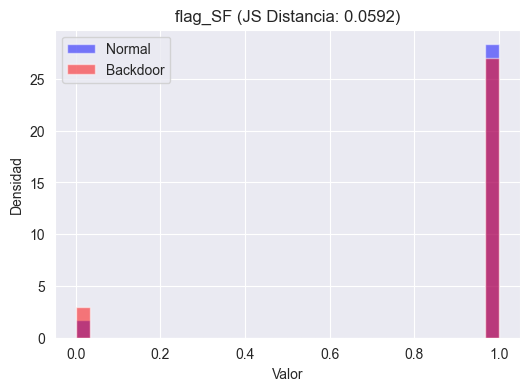

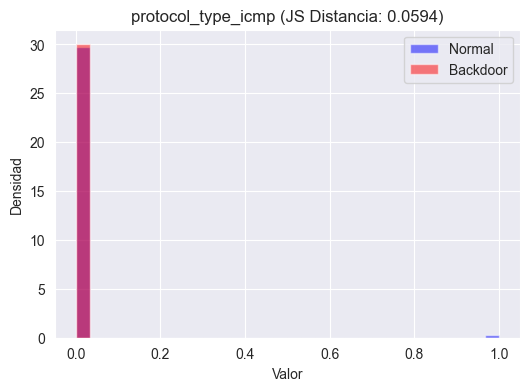

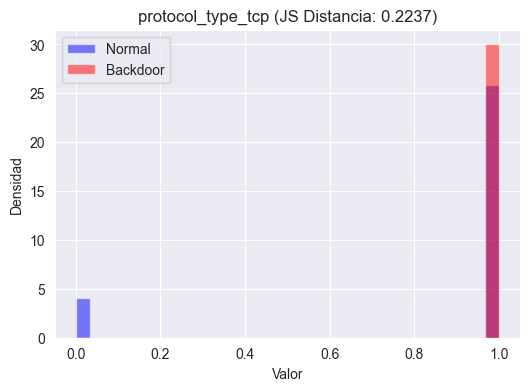

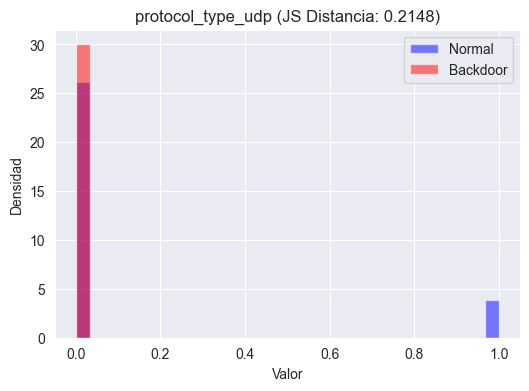

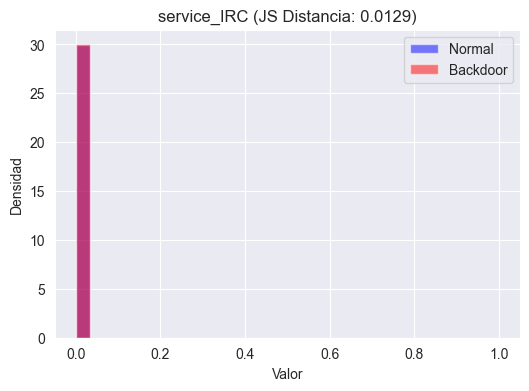

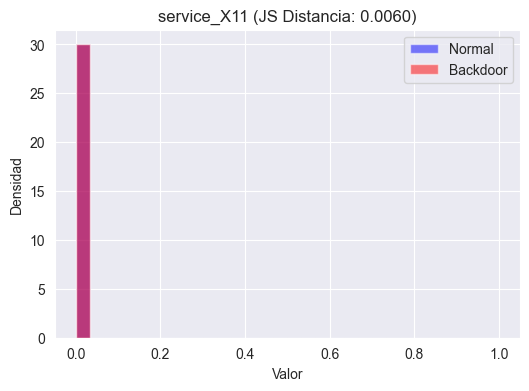

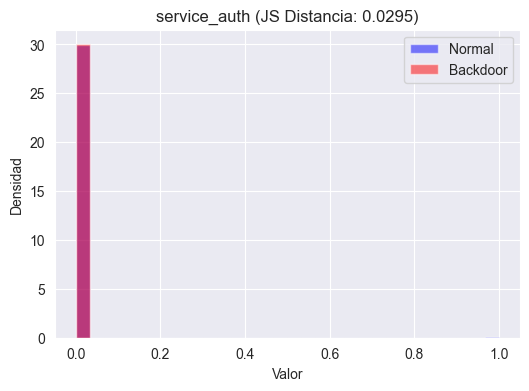

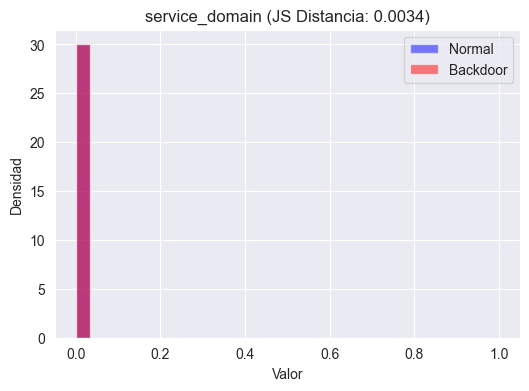

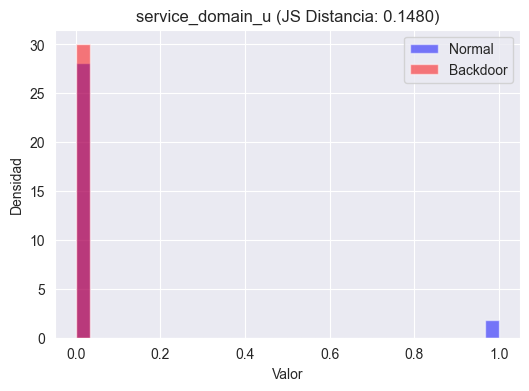

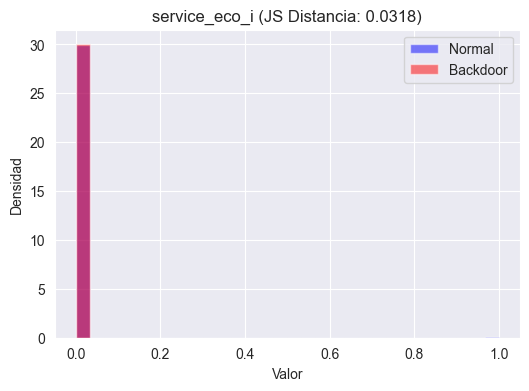

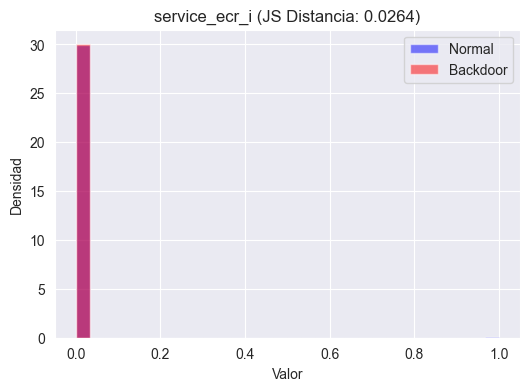

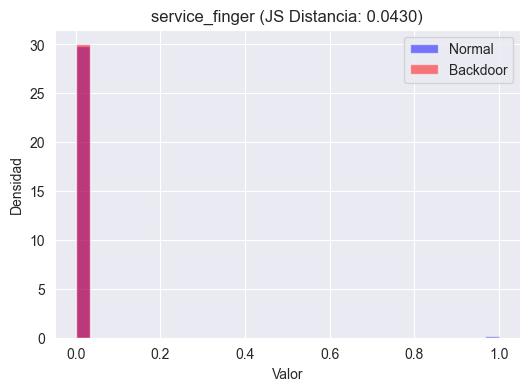

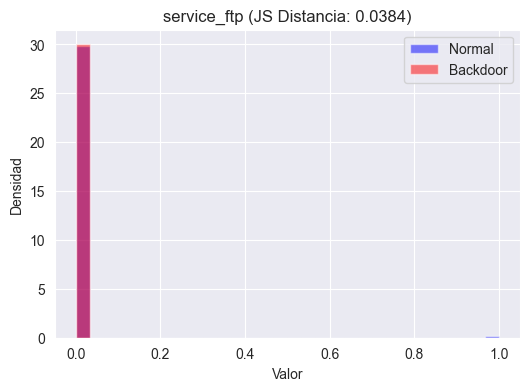

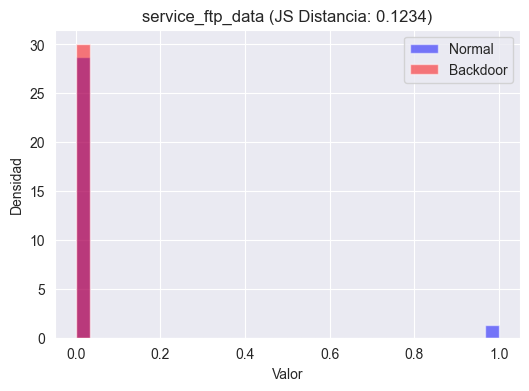

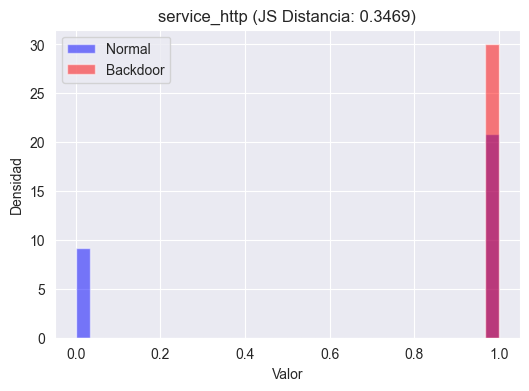

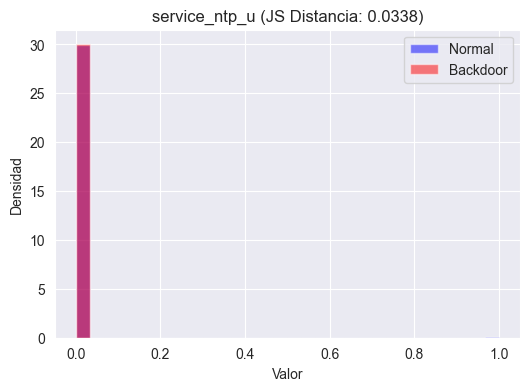

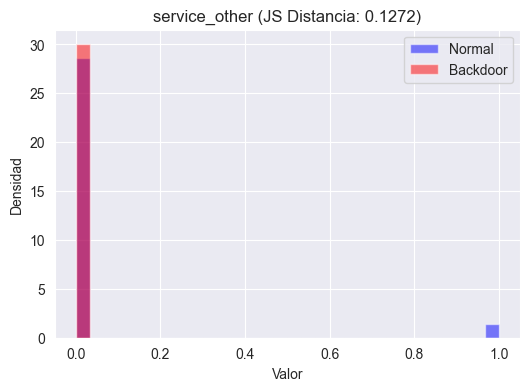

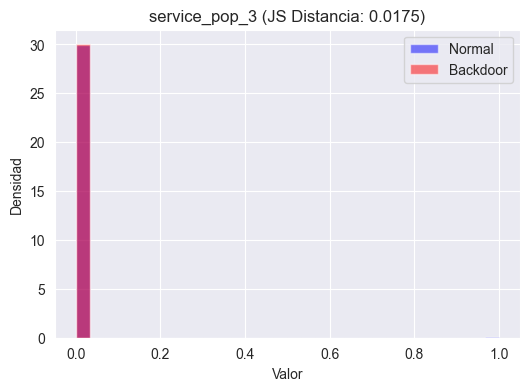

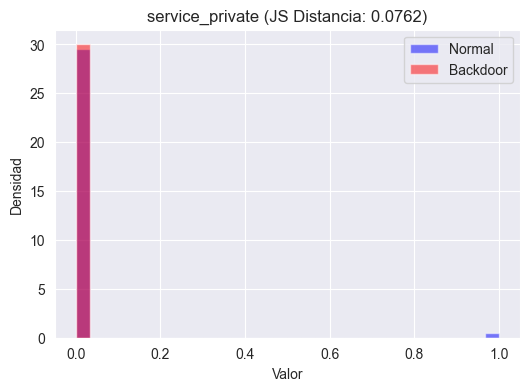

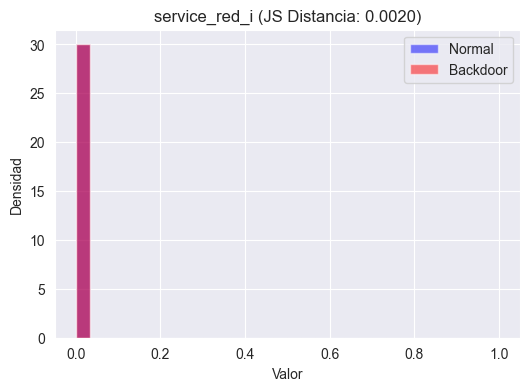

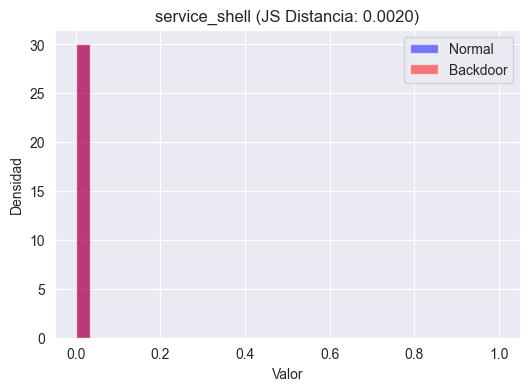

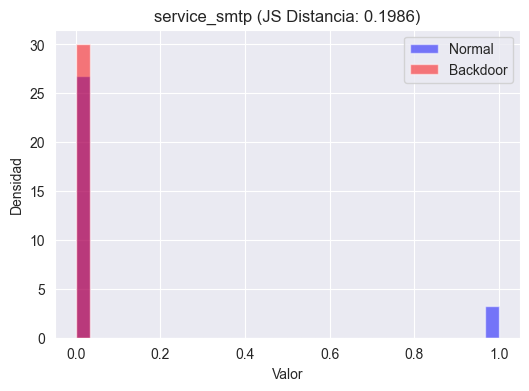

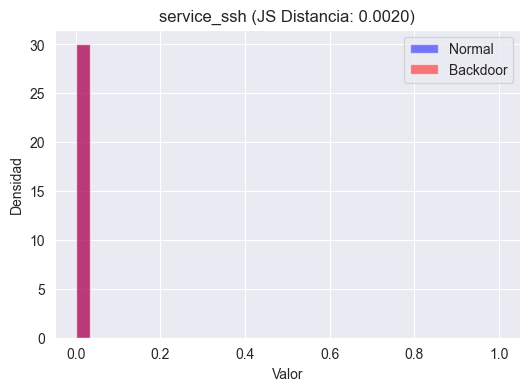

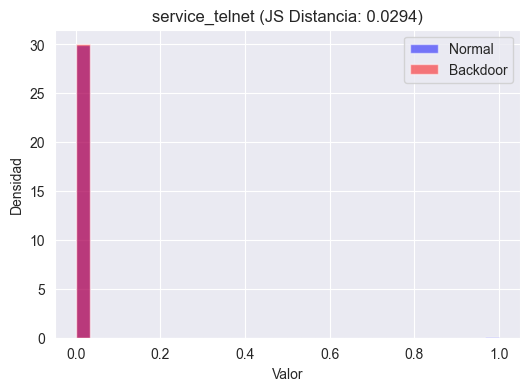

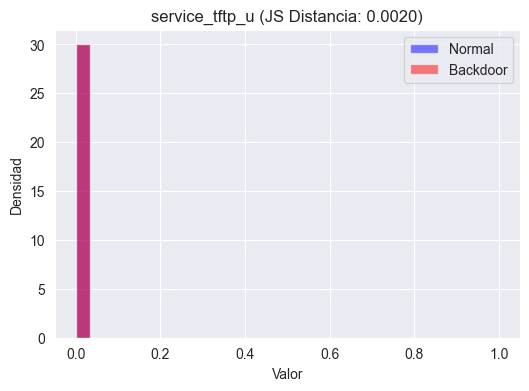

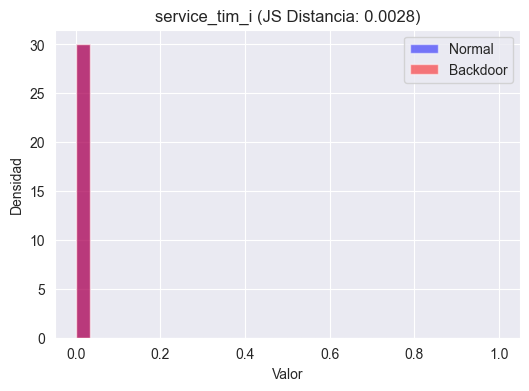

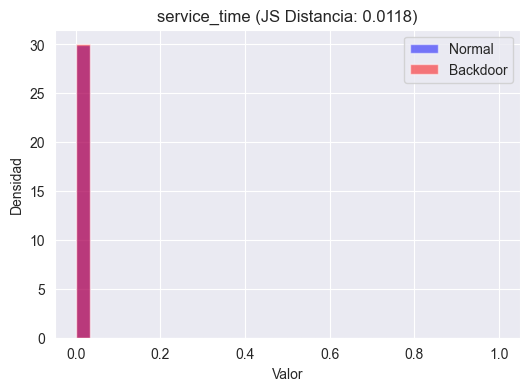

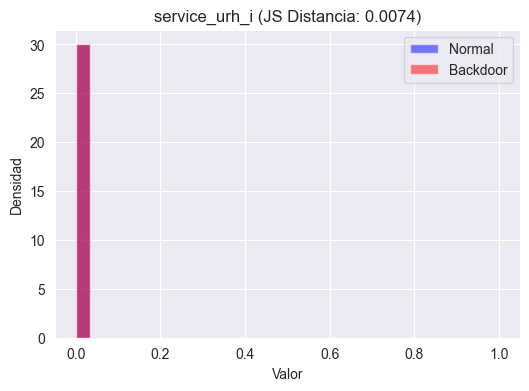

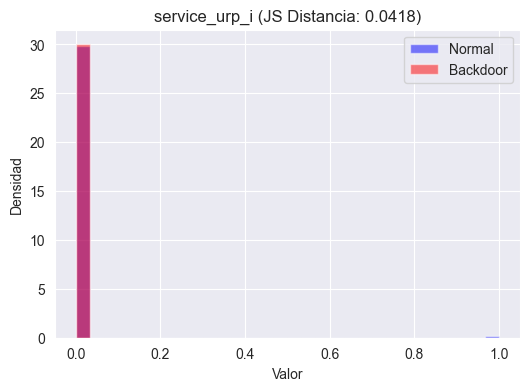

In [16]:
analyze_js_distance_separated(df_no_attacks_without_outcome, df_attacks_without_outcome, attack_without_outcomes_column_names)